In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

# 2-D advection

In [2]:
def Numeric(dt, scheme):
    cx, cy = 0.1, 0.1
    xs     = np.linspace(0., 1., 101)
    ys     = np.linspace(0., 1., 101)
    dx     = xs[1] - xs[0]
    dy     = ys[1] - ys[0]
    ts     = np.arange(0., 10. + dt, dt)
    phis   = np.full((len(ts), len(ys), len(xs)), np.nan, dtype = float)
    
    # Initial profile
    for j, y in enumerate(ys):
        for k, x in enumerate(xs):
            if (x >= 0.3) & (x <= 0.7) & (y >= 0.3) & (y <= 0.7):
                phis[0, j, k] = 1.
            else:
                phis[0, j, k] = 0.
    
    for i, t in tqdm(enumerate(ts[1 :]), total = len(ts[1 :])):
        i += 1
        for j, y in enumerate(ys[1 : -1]):
            j += 1
            for k, x in enumerate(xs[1 : -1]):
                k += 1
                
                if k == 1:
                    phikp1 = phis[i - 1, j, k + 1]
                    phikm1 = phis[i - 1, j,    -2]
                elif k == len(xs[1 : -1]):
                    phikp1 = phis[i - 1, j,     1]
                    phikm1 = phis[i - 1, j, k - 1]
                else:
                    phikp1 = phis[i - 1, j, k + 1]
                    phikm1 = phis[i - 1, j, k - 1]
                
                if j == 1:
                    phijp1 = phis[i - 1, j + 1, k]
                    phijm1 = phis[i - 1,    -2, k]
                elif j == len(ys[1 : -1]):
                    phijp1 = phis[i - 1,     1, k]
                    phijm1 = phis[i - 1, j - 1, k]
                else:
                    phijp1 = phis[i - 1, j + 1, k]
                    phijm1 = phis[i - 1, j - 1, k]
                    
                if scheme == "FE_CD2":
                    phis[i, j, k] = phis[i - 1, j, k] - dt * cx * (phikp1 - phikm1) / (2. * dx) - dt * cy * (phijp1 - phijm1) / (2. * dy)
                
                elif scheme == "FE_UP1":
                    phis[i, j, k] = phis[i - 1, j, k] - dt * cx * (phis[i - 1, j, k] - phikm1) / dx - dt * cy * (phis[i - 1, j, k] - phijm1) / dy
                
                elif scheme == "LF_CD2":
                    if i == 1:
                        phis[i, j, k] = phis[i - 1, j, k] - dt * cx * (phikp1 - phikm1) / (2. * dx) - dt * cy * (phijp1 - phijm1) / (2. * dy)
                    else:
                        phis[i, j, k] = phis[i - 2, j, k] - dt * cx * (phikp1 - phikm1) / dx - dt * cy * (phijp1 - phijm1) / dy
                
        # Boundary condition: periodic
        phis[i,  0] = phis[i, -2]
        phis[i, -1] = phis[i,  1]
        
        phis[i, :,  0] = phis[i, :, -2]
        phis[i, :, -1] = phis[i, :,  1]
    
    return xs, ys, ts, phis

In [45]:
dt = 0.001
xs, ys, ts, fe_cd2 = Numeric(dt, "FE_CD2")
xs, ys, ts, fe_up1 = Numeric(dt, "FE_UP1")
xs, ys, ts, lf_cd2 = Numeric(dt, "LF_CD2")

100%|██████████| 10000/10000 [04:42<00:00, 35.46it/s]


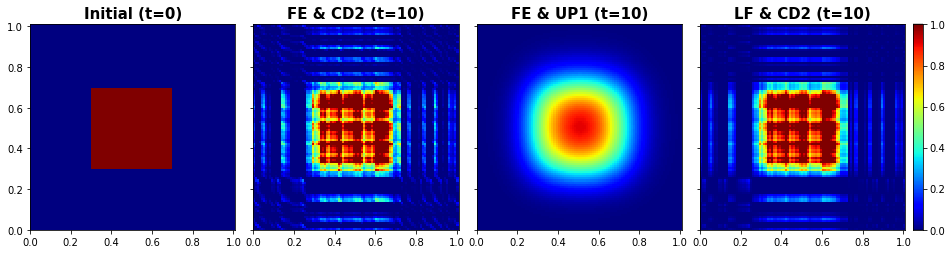

In [46]:
fig  = plt.figure(figsize = (16, 4))
subs = ImageGrid(fig, 111, nrows_ncols = (1, 4), axes_pad = 0.25, share_all = True,\
                 cbar_mode = "single", cbar_location = "right", cbar_pad = 0.1)

tsPlot  = [0., 10., 10., 10.]
schemes = ["Initial (t=0)", "FE & CD2 (t=10)", "FE & UP1 (t=10)", "LF & CD2 (t=10)"]

xx, yy = np.meshgrid(np.linspace(0., 1.01, 102), np.linspace(0., 1.01, 102))

for s, scheme in enumerate(schemes):
    sub = subs[s]
    
    sub.set_title("%s" % scheme, fontsize = 15, fontdict = {"weight": "bold"})
    
    plot = sub.pcolor(xx, yy, [fe_cd2, fe_cd2, fe_up1, lf_cd2][s][np.where(ts == tsPlot[s])[0][0]], cmap = "jet", vmin = 0, vmax = 1)

subs.cbar_axes[0].colorbar(plot)

plt.savefig("./HW4/2d_%s.png" % dt, dpi = 500, bbox_inches = "tight")

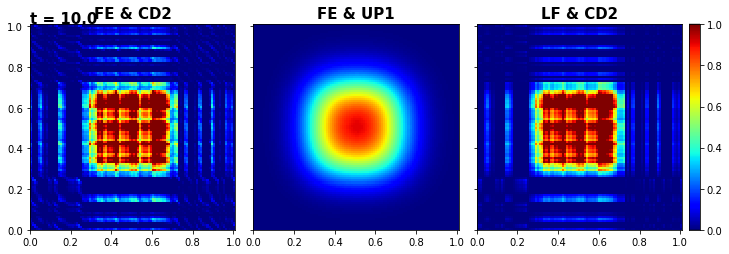

In [47]:
fig  = plt.figure(figsize = (12, 4))
subs = ImageGrid(fig, 111, nrows_ncols = (1, 3), axes_pad = 0.25, share_all = True,\
                 cbar_mode = "single", cbar_location = "right", cbar_pad = 0.1)

subs[0].set_title("FE & CD2", fontsize = 15, fontdict = {"weight": "bold"})
subs[1].set_title("FE & UP1", fontsize = 15, fontdict = {"weight": "bold"})
subs[2].set_title("LF & CD2", fontsize = 15, fontdict = {"weight": "bold"})

xx, yy = np.meshgrid(np.linspace(0., 1.01, 102), np.linspace(0., 1.01, 102))

plot0 = subs[0].pcolormesh(xx, yy, np.zeros(fe_cd2[0].shape), cmap = "jet", vmin = 0, vmax = 1)
plot1 = subs[1].pcolormesh(xx, yy, np.zeros(fe_up1[0].shape), cmap = "jet", vmin = 0, vmax = 1)
plot2 = subs[2].pcolormesh(xx, yy, np.zeros(lf_cd2[0].shape), cmap = "jet", vmin = 0, vmax = 1)
text  = subs[0].text(0, 1., "", ha = "left", va = "bottom", fontsize = 15, fontdict = {"weight": "bold"})

subs.cbar_axes[0].colorbar(plot0)

def animate(i):
    plot0.set_array(fe_cd2[i].flatten(order = "C"))
    plot1.set_array(fe_up1[i].flatten(order = "C"))
    plot2.set_array(lf_cd2[i].flatten(order = "C"))
    text.set_text("t = %.1f" % ts[i])
    
    return (plot0, plot1, plot2, text,)

anim = animation.FuncAnimation(fig, animate, frames = np.arange(len(ts))[:: 100], interval = 100, blit = True)

anim.save("./HW4/2d_anim_%s.mp4" % dt)

HTML(anim.to_html5_video())